In [2]:
from pathlib import Path
import pandas as pd
import json
import pyarrow as pa
import matplotlib

import sklearn
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import numpy as np

In [3]:
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = None

In [4]:
#MOA
data_dir_moa = Path('C:/Users/Sanjana/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/mechanismOfAction/')
moa_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_moa.glob('*.parquet')
)

#AE
data_dir = Path('C:/Users/Sanjana/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/fda/significantAdverseDrugReactions/')
ae_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)

#TARGETS-PATHWAY
data_dir_targets = Path('C:/Users/Sanjana/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/targets/')
targets_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_targets.glob('*.parquet')
)

In [5]:
#target AE
data_dir_target_ae = Path('C:/Users/Sanjana/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/fda/significantAdverseTargetReactions/')
target_ae_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_target_ae.glob('*.parquet')
)

In [6]:
#Indications
data_dir_indications = Path('C:/Users/Sanjana/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/indication/')
indications_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_indications.glob('*.parquet')
)

### Mechanism of Action

In [7]:
select_moa_full_df = moa_full_df[['chemblIds','actionType','mechanismOfAction','targetName','targetType','targets']]
exploded_moa = select_moa_full_df.explode('chemblIds')
exploded_moa = exploded_moa.explode('targets')
exploded_moa = exploded_moa.apply(lambda x : x.str.strip())

### Flatten pathway from Target dataframe

In [8]:
target_pathway = targets_full_df[targets_full_df.pathways.notnull()]

target_pathway = target_pathway[['id','approvedName', 'pathways']]

target_pathway = target_pathway[['id','approvedName', 'pathways']]

target_pathway = target_pathway[target_pathway.id.notnull()]

exploded_target_pathway = target_pathway.explode('pathways')

exploded_target_pathway['pathways'] =  exploded_target_pathway['pathways'].astype("string")

exploded_target_pathway['pathways'] = exploded_target_pathway.pathways.str.strip('{}')

exploded_target_pathway['pathways'] = exploded_target_pathway.pathways.str.replace("'",'')

pathways= exploded_target_pathway['pathways']

### Split pathway column into three columns - 'pathwayId', 'pathway','topLevelTerm'

In [9]:
pathways =  exploded_target_pathway.pathways.astype(str).str.split(",",expand=True)

pathways.columns = ["pathwayId", "pathway","topLevelTerm","empty1","empty2","empty3"]

pathways.drop(pathways.columns[[3,4,5]],axis=1,inplace=True)

### Lamda function to strip unwanted characters

In [10]:
pathways = pathways.apply(lambda x : x.str.split('\:').str[-1].str.strip())

### Merge back pathway columns - 'pathwayId', 'pathway' and 'topLevelTerm' to 'exploded_target_pathways' dataframe

In [11]:
wide_taget_pathway = pd.concat([exploded_target_pathway,pathways],axis=1)

wide_taget_pathway = wide_taget_pathway.drop('pathways',axis=1)

wide_taget_pathway = wide_taget_pathway.apply(lambda x : x.str.strip())

### Merge drug, target, pathway and mechanism of action information from  'exploded_moa' with 'wide_target_pathway'

In [12]:
drug_targets_moa_pathway = pd.merge(exploded_moa,wide_taget_pathway, left_on='targets',right_on = 'id',how='left')

drug_targets_moa_pathway = drug_targets_moa_pathway.drop('id', axis = 1)

clean_drug_targets_moa_pathway = drug_targets_moa_pathway[drug_targets_moa_pathway.pathway.notnull()]

clean_drug_targets_moa_pathway = clean_drug_targets_moa_pathway[clean_drug_targets_moa_pathway.targets.notnull()]

In [13]:
clean_drug_targets_moa_pathway = clean_drug_targets_moa_pathway.drop_duplicates(subset= ['chemblIds'	,'actionType'	,'mechanismOfAction'	,'targetName',	'targetType',	'targets',	'approvedName',	'pathwayId',	'pathway',	'topLevelTerm'])

### Merge Indications

In [14]:
indications_full_df = indications_full_df[indications_full_df.id.notnull()]

exploded_indications = indications_full_df.explode('approvedIndications')

exploded_indications.drop(['indications','indicationCount'], axis =1,inplace=True)

exploded_indications = exploded_indications[exploded_indications.approvedIndications.notna()]

exploded_indications = exploded_indications.drop_duplicates(subset = ['id','approvedIndications'])

### New unified dataset with Indications , Action type, Target; removed Mechanism of action

In [15]:
drug_targets_moa_pathway_indications = pd.merge(clean_drug_targets_moa_pathway,exploded_indications, left_on='chemblIds',right_on = 'id',how='left')

In [16]:
drug_targets_moa_pathway_indications.drop(['id','targetName','targetType', 'pathwayId','pathway','mechanismOfAction','approvedName'],axis=1,inplace=True)

clean_drug_targets_moa_pathway_indications = drug_targets_moa_pathway_indications.drop_duplicates(subset=['chemblIds','actionType','targets','topLevelTerm','approvedIndications'])

In [17]:
clean_drug_targets_moa_pathway_indications = clean_drug_targets_moa_pathway_indications.rename(columns = {'topLevelTerm': 'pathwayCategory'})

### Omit drugs without indications; 2831 drugs do not have approved indications

In [18]:
clean_drug_targets_moa_pathway_indications = clean_drug_targets_moa_pathway_indications[~clean_drug_targets_moa_pathway_indications.approvedIndications.isna()]

### ADVERSE EVENTS dataset

#### Group AE

In [20]:
drug_adverse_events_grouped = ae_full_df.groupby('chembl_id')['event'].apply(list).reset_index(name='adverse_events')

In [21]:
target_ae_grouped = target_ae_full_df.groupby('targetId')['event'].apply(list).reset_index(name='adverse_events')

### Select targets with Adverse events

In [23]:
clean_drug_targets_moa_pathway_indications

chemblIds  actionType          targets      pathwayCategory   
0       CHEMBL3545367  ANTAGONIST  ENSG00000137252  Signal Transduction  \
2       CHEMBL2028987  ANTAGONIST  ENSG00000109163  Signal Transduction   
3       CHEMBL2028987  ANTAGONIST  ENSG00000109163  Signal Transduction   
4       CHEMBL2028987  ANTAGONIST  ENSG00000109163  Signal Transduction   
8        CHEMBL415606  ANTAGONIST  ENSG00000109163  Signal Transduction   
...               ...         ...              ...                  ...   
210057   CHEMBL461522   INHIBITOR  ENSG00000073756           Metabolism   
210060   CHEMBL461522   INHIBITOR  ENSG00000073756        Immune System   
210061   CHEMBL461522   INHIBITOR  ENSG00000073756        Immune System   
210074   CHEMBL461522   INHIBITOR  ENSG00000095303           Metabolism   
210075   CHEMBL461522   INHIBITOR  ENSG00000095303           Metabolism   

       approvedIndications  
0              EFO_0004698  
2              EFO_0000673  
3            MONDO_0008315  
4              EFO_0001663  
8              EFO_0000616  
...                    ...  
210057         EFO_0003843  
210060          HP_0001945  
210061         EFO_0003843  
210074          HP_0001945  
210075         EFO_0003843  

[54141 rows x 5 columns]

In [24]:
known_targets_with_ae =  clean_drug_targets_moa_pathway_indications[clean_drug_targets_moa_pathway_indications.targets.isin(target_ae_grouped['targetId'])]

known_drugs_with_ae = clean_drug_targets_moa_pathway_indications[clean_drug_targets_moa_pathway_indications.chemblIds.isin(drug_adverse_events_grouped['chembl_id'])]

targets_without_ae =  clean_drug_targets_moa_pathway_indications[~clean_drug_targets_moa_pathway_indications.targets.isin(target_ae_grouped['targetId'])]

drugs_without_ae = clean_drug_targets_moa_pathway_indications[~clean_drug_targets_moa_pathway_indications.chemblIds.isin(drug_adverse_events_grouped['chembl_id'])]

## Concat  drugs and targets with known AEs

In [25]:
known_drug_target_ae =  pd.concat([known_targets_with_ae,known_drugs_with_ae]).drop_duplicates()

In [31]:
known_drug_target_ae['drug_target'] = known_drug_target_ae[['chemblIds','targets']].agg('-'.join, axis=1)

In [35]:
known_drug_target_ae = known_drug_target_ae.drop(['chemblIds','targets'], axis =1)

In [37]:
known_drug_target_ae = known_drug_target_ae[['drug_target','actionType','pathwayCategory','approvedIndications']]

### Drug Target Adverse events

In [137]:
combined_ae_drug_target_pair = pd.concat([known_targets_with_ae,known_drugs_with_ae]).drop_duplicates()

combined_ae_drug_target_pair = pd.merge(pd.merge(combined_ae_drug_target_pair,drug_adverse_events_grouped, left_on='chemblIds', right_on='chembl_id', how='left') , target_ae_grouped , left_on='targets', right_on='targetId', how ='left')

combined_ae_drug_target_pair = combined_ae_drug_target_pair.drop(['chembl_id','targetId'],axis =1)

combined_ae_drug_target_pair['adverse_events'] = combined_ae_drug_target_pair['adverse_events_x'] + combined_ae_drug_target_pair['adverse_events_y']

combined_ae_drug_target_pair = combined_ae_drug_target_pair[combined_ae_drug_target_pair.adverse_events.notna()]

clean_drug_target_adverse_events = combined_ae_drug_target_pair.drop(['actionType','pathwayCategory','approvedIndications','adverse_events_x','adverse_events_y'],axis =1)

clean_drug_target_adverse_events = clean_drug_target_adverse_events.drop_duplicates(['chemblIds','targets'])

clean_drug_target_adverse_events['drug_target'] =  clean_drug_target_adverse_events[['chemblIds','targets']].agg('-'.join, axis=1)

clean_drug_target_adverse_events = clean_drug_target_adverse_events.drop(['chemblIds','targets'],axis=1)

clean_drug_target_adverse_events = clean_drug_target_adverse_events[['drug_target','adverse_events']]

## Data Split

### Split Train, test, cv data into 60,20,20 ratio

In [41]:
train, validation, test = \
              np.split(known_drug_target_ae.sample(frac=1, random_state=42), 
                       [int(.6*len(known_drug_target_ae)), int(.8*len(known_drug_target_ae))])  #  train =0.6, val = 1-0.8,  test = diff(0.6-0.8)

### Cross Validation

In [42]:
# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold

# prepare cross validation
np.random.seed(100)
kf = KFold(n_splits=5, shuffle=True, random_state=0)
#Split train into K=5 folds
for i, (_, v_ind) in enumerate(kf.split(validation)):
    validation.loc[validation.index[v_ind], 'kfold'] = f"fold{i+1}"

In [43]:
fold_1 = validation.loc[validation['kfold']=='fold1',validation.columns!='kfold']
fold_2 = validation.loc[validation['kfold']=='fold2',validation.columns!='kfold']
fold_3 = validation.loc[validation['kfold']=='fold3',validation.columns!='kfold']
fold_4 = validation.loc[validation['kfold']=='fold4',validation.columns!='kfold']
fold_5 = validation.loc[validation['kfold']=='fold5',validation.columns!='kfold']

### Encode categorical columns

In [45]:
one_hot_encoded = pd.get_dummies(train, columns= ["actionType","pathwayCategory","approvedIndications"])

one_hot_encoded = one_hot_encoded.groupby(['drug_target']).sum().clip(upper=1)

In [138]:
one_hot_encoded

actionType_ACTIVATOR  actionType_AGONIST   
drug_target                                                              
CHEMBL1000-ENSG00000196639                       0                   0  \
CHEMBL100116-ENSG00000147955                     0                   0   
CHEMBL1002-ENSG00000169252                       0                   1   
CHEMBL1004-ENSG00000196639                       0                   0   
CHEMBL1008-ENSG00000006116                       0                   0   
...                                            ...                 ...   
CHEMBL9967-ENSG00000168539                       0                   0   
CHEMBL997-ENSG00000160752                        0                   0   
CHEMBL998-ENSG00000196639                        0                   0   
CHEMBL99946-ENSG00000103546                      0                   0   
CHEMBL99946-ENSG00000108576                      0                   0   

                              actionType_ANTAGONIST   
drug_target                                           
CHEMBL1000-ENSG00000196639                        1  \
CHEMBL100116-ENSG00000147955                      0   
CHEMBL1002-ENSG00000169252                        0   
CHEMBL1004-ENSG00000196639                        1   
CHEMBL1008-ENSG00000006116                        0   
...                                             ...   
CHEMBL9967-ENSG00000168539                        1   
CHEMBL997-ENSG00000160752                         0   
CHEMBL998-ENSG00000196639                         1   
CHEMBL99946-ENSG00000103546                       0   
CHEMBL99946-ENSG00000108576                       0   

                              actionType_ANTISENSE INHIBITOR   
drug_target                                                    
CHEMBL1000-ENSG00000196639                                 0  \
CHEMBL100116-ENSG00000147955                               0   
CHEMBL1002-ENSG00000169252                                 0   
CHEMBL1004-ENSG00000196639                                 0   
CHEMBL1008-ENSG00000006116                                 0   
...                                                      ...   
CHEMBL9967-ENSG00000168539                                 0   
CHEMBL997-ENSG00000160752                                  0   
CHEMBL998-ENSG00000196639                                  0   
CHEMBL99946-ENSG00000103546                                0   
CHEMBL99946-ENSG00000108576                                0   

                              actionType_BINDING AGENT  actionType_BLOCKER   
drug_target                                                                  
CHEMBL1000-ENSG00000196639                           0                   0  \
CHEMBL100116-ENSG00000147955                         0                   0   
CHEMBL1002-ENSG00000169252                           0                   0   
CHEMBL1004-ENSG00000196639                           0                   0   
CHEMBL1008-ENSG00000006116                           0                   1   
...                                                ...                 ...   
CHEMBL9967-ENSG00000168539                           0                   0   
CHEMBL997-ENSG00000160752                            0                   0   
CHEMBL998-ENSG00000196639                            0                   0   
CHEMBL99946-ENSG00000103546                          0                   0   
CHEMBL99946-ENSG00000108576                          0                   0   

                              actionType_CROSS-LINKING AGENT   
drug_target                                                    
CHEMBL1000-ENSG00000196639                                 0  \
CHEMBL100116-ENSG00000147955                               0   
CHEMBL1002-ENSG00000169252                                 0   
CHEMBL1004-ENSG00000196639                                 0   
CHEMBL1008-ENSG00000006116                                 0   
...                                                    

### Convert to numpy array

In [47]:
nd_array = one_hot_encoded.to_numpy()

In [48]:
import threading
threading.active_count()

7

# Similarity

### Calculate Similarity -Jaccard

In [49]:
jac_sim = 1 - pairwise_distances(nd_array, metric='jaccard',n_jobs =-2)

jac_sim_df = pd.DataFrame(jac_sim, index= one_hot_encoded.index, columns=one_hot_encoded.index)

c:\Users\ArulSeetharaman\Miniconda3\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [50]:
jac_sim_df

drug_target                   CHEMBL1000-ENSG00000196639   
drug_target                                                
CHEMBL1000-ENSG00000196639                      1.000000  \
CHEMBL100116-ENSG00000147955                    0.000000   
CHEMBL1002-ENSG00000169252                      0.111111   
CHEMBL1004-ENSG00000196639                      0.500000   
CHEMBL1008-ENSG00000006116                      0.000000   
...                                                  ...   
CHEMBL9967-ENSG00000168539                      0.250000   
CHEMBL997-ENSG00000160752                       0.000000   
CHEMBL998-ENSG00000196639                       0.714286   
CHEMBL99946-ENSG00000103546                     0.000000   
CHEMBL99946-ENSG00000108576                     0.000000   

drug_target                   CHEMBL100116-ENSG00000147955   
drug_target                                                  
CHEMBL1000-ENSG00000196639                           0.000  \
CHEMBL100116-ENSG00000147955                         1.000   
CHEMBL1002-ENSG00000169252                           0.000   
CHEMBL1004-ENSG00000196639                           0.000   
CHEMBL1008-ENSG00000006116                           0.000   
...                                                    ...   
CHEMBL9967-ENSG00000168539                           0.000   
CHEMBL997-ENSG00000160752                            0.000   
CHEMBL998-ENSG00000196639                            0.000   
CHEMBL99946-ENSG00000103546                          0.125   
CHEMBL99946-ENSG00000108576                          0.000   

drug_target                   CHEMBL1002-ENSG00000169252   
drug_target                                                
CHEMBL1000-ENSG00000196639                      0.111111  \
CHEMBL100116-ENSG00000147955                    0.000000   
CHEMBL1002-ENSG00000169252                      1.000000   
CHEMBL1004-ENSG00000196639                      0.166667   
CHEMBL1008-ENSG00000006116                      0.000000   
...                                                  ...   
CHEMBL9967-ENSG00000168539                      0.142857   
CHEMBL997-ENSG00000160752                       0.000000   
CHEMBL998-ENSG00000196639                       0.111111   
CHEMBL99946-ENSG00000103546                     0.000000   
CHEMBL99946-ENSG00000108576                     0.000000   

drug_target                   CHEMBL1004-ENSG00000196639   
drug_target                                                
CHEMBL1000-ENSG00000196639                      0.500000  \
CHEMBL100116-ENSG00000147955                    0.000000   
CHEMBL1002-ENSG00000169252                      0.166667   
CHEMBL1004-ENSG00000196639                      1.000000   
CHEMBL1008-ENSG00000006116                      0.000000   
...                                                  ...   
CHEMBL9967-ENSG00000168539                      0.400000   
CHEMBL997-ENSG00000160752                       0.000000   
CHEMBL998-ENSG00000196639                       0.500000   
CHEMBL99946-ENSG00000103546                     0.000000   
CHEMBL99946-ENSG00000108576                     0.000000   

drug_target                   CHEMBL1008-ENSG00000006116   
drug_target                                                
CHEMBL1000-ENSG00000196639                           0.0  \
CHEMBL100116-ENSG00000147955                         0.0   
CHEMBL1002-ENSG00000169252                           0.0   
CHEMBL1004-ENSG00000196639                           0.0   
CHEMBL1008-ENSG00000006116                           1.0   
...                                                  ...   
CHEMBL9967-ENSG00000168539                           0.0   
CHEMBL997-ENSG00000160752                            0.0   
CHEMBL998-ENSG00000196639                            0.0   
CHEMBL99946-ENSG00000103546                          0.0   
CHEMBL99946-ENSG00000108576                          0.2   

drug_target                   CHEMBL1008-ENSG00000006283   
drug_targ

### Transform to Longform

In [62]:
# move to long form
long_form = jac_sim_df.unstack()


In [63]:
# rename columns and turn into a dataframe
long_form.index.rename(['drug_target_1', 'drug_target_2'], inplace=True)
long_form = long_form.to_frame('jaccard_similarity').reset_index()

In [66]:
long_form

drug_target_1                  drug_target_2   
3            CHEMBL1000-ENSG00000196639     CHEMBL1004-ENSG00000196639  \
12563406   CHEMBL288441-ENSG00000186716   CHEMBL502835-ENSG00000066468   
12563407   CHEMBL288441-ENSG00000186716   CHEMBL502835-ENSG00000068078   
12563409   CHEMBL288441-ENSG00000186716   CHEMBL502835-ENSG00000102755   
12563411   CHEMBL288441-ENSG00000186716   CHEMBL502835-ENSG00000128052   
...                                 ...                            ...   
3648076   CHEMBL1201234-ENSG00000043591  CHEMBL2311030-ENSG00000169676   
3648079   CHEMBL1201234-ENSG00000043591  CHEMBL2311030-ENSG00000178394   
3648081   CHEMBL1201234-ENSG00000043591  CHEMBL2311030-ENSG00000184845   
14657874    CHEMBL37744-ENSG00000164270     CHEMBL1113-ENSG00000149295   
17687692      CHEMBL517-ENSG00000136531  CHEMBL1201020-ENSG00000136531   

          jaccard_similarity  
3                        0.5  
12563406                 0.5  
12563407                 0.5  
12563409                 0.5  
12563411                 0.5  
...                      ...  
3648076                  1.0  
3648079                  1.0  
3648081                  1.0  
14657874                 1.0  
17687692                 1.0  

[346138 rows x 3 columns]

In [65]:


long_form = long_form[
    (long_form['jaccard_similarity'] >= 0.50) 
    & 
        (long_form['drug_target_1'] != long_form['drug_target_2'])
].sort_values('jaccard_similarity',ascending = True)

long_form['jaccard_similarity'] = round(long_form['jaccard_similarity'],2)

## Score Distribution

<Axes: >

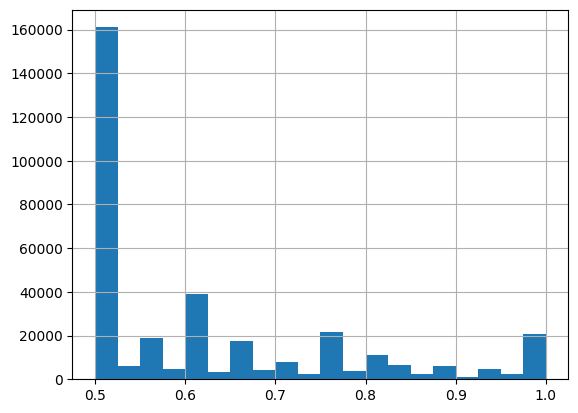

In [67]:
long_form.jaccard_similarity.hist(bins='sturges')


In [150]:
#score_distribution

### Drop multiple comparisons (duplicate target pairs)

In [68]:
similar_drug_targets = long_form.drop_duplicates(subset=['drug_target_1','drug_target_2'])

In [139]:
similar_drug_targets

drug_target_1                  drug_target_2   
3            CHEMBL1000-ENSG00000196639     CHEMBL1004-ENSG00000196639  \
12563406   CHEMBL288441-ENSG00000186716   CHEMBL502835-ENSG00000066468   
12563407   CHEMBL288441-ENSG00000186716   CHEMBL502835-ENSG00000068078   
12563409   CHEMBL288441-ENSG00000186716   CHEMBL502835-ENSG00000102755   
12563411   CHEMBL288441-ENSG00000186716   CHEMBL502835-ENSG00000128052   
...                                 ...                            ...   
3648076   CHEMBL1201234-ENSG00000043591  CHEMBL2311030-ENSG00000169676   
3648079   CHEMBL1201234-ENSG00000043591  CHEMBL2311030-ENSG00000178394   
3648081   CHEMBL1201234-ENSG00000043591  CHEMBL2311030-ENSG00000184845   
14657874    CHEMBL37744-ENSG00000164270     CHEMBL1113-ENSG00000149295   
17687692      CHEMBL517-ENSG00000136531  CHEMBL1201020-ENSG00000136531   

          jaccard_similarity  
3                        0.5  
12563406                 0.5  
12563407                 0.5  
12563409                 0.5  
12563411                 0.5  
...                      ...  
3648076                  1.0  
3648079                  1.0  
3648081                  1.0  
14657874                 1.0  
17687692                 1.0  

[346138 rows x 3 columns]

### Group drugs and targets by adverse events

In [72]:
#target_ae_grouped = target_ae_full_df.groupby('targetId')['event'].apply(list).reset_index(name='adverse_events')

#drug_adverse_events_grouped = ae_full_df.groupby('chembl_id')['event'].apply(list).reset_index(name='adverse_events')

### Combined AEs from drugs and Targets

In [ ]:
clean_drug_target_adverse_events

In [143]:
#train_drug_target_adverse_events

In [141]:
train_drug_target_adverse_events = clean_drug_target_adverse_events[~clean_drug_target_adverse_events.drug_target.isin(validation.drug_target)]

In [284]:
test_drug_target_adverse_events = clean_drug_target_adverse_events[~clean_drug_target_adverse_events.drug_target.isin(test.drug_target)]

In [315]:
#train_target_ae_grouped

### Merge similar drug-targets with Adverse Events

In [310]:
similar_drug_targets_ae = pd.merge(similar_drug_targets,train_drug_target_adverse_events, left_on= 'drug_target_1'  , right_on = 'drug_target'  , how ='left')
similar_drug_targets_ae = pd.merge(similar_drug_targets_ae,train_drug_target_adverse_events, left_on= 'drug_target_2'  , right_on = 'drug_target'  , how ='left')



In [311]:
similar_drug_targets_ae = similar_drug_targets_ae[(similar_drug_targets_ae.drug_target_x.notna()) & (similar_drug_targets_ae.drug_target_y.notna())]

isna = similar_drug_targets_ae['adverse_events_x'].isna()
similar_drug_targets_ae.loc[isna,'adverse_events_x'] = pd.Series([[]] * isna.sum()).values

isnay = similar_drug_targets_ae['adverse_events_y'].isna()
similar_drug_targets_ae.loc[isnay,'adverse_events_y'] = pd.Series([[]] * isnay.sum()).values

In [168]:
#similar_drug_targets_ae

### Find common AEs

In [312]:
similar_drug_targets_ae['common_adverse_events'] = [list(set(a).intersection(set(b))) for a, b in zip(similar_drug_targets_ae.adverse_events_x, similar_drug_targets_ae.adverse_events_y)]

### Group Drug -Targets

In [313]:
similar_drug_targets_ae['common_adverse_events'] = similar_drug_targets_ae.common_adverse_events.astype("string").str.replace('[', '').str.replace(']', '').str.replace('"', '')

In [314]:
similar_drug_targets_ae_grouped = similar_drug_targets_ae.groupby('drug_target_1')[['drug_target_2','common_adverse_events']].agg(lambda x: list(x)).reset_index()

In [315]:
similar_drug_targets_ae_grouped['common_adverse_events'] = similar_drug_targets_ae_grouped.common_adverse_events.astype("string").str.replace('[', '').str.replace(']', '').str.replace('"', '')

In [308]:
#similar_drug_targets_ae_grouped

### Remove Duplicate AEs

In [316]:
similar_drug_targets_ae_grouped['unique_ae'] = similar_drug_targets_ae_grouped['common_adverse_events'].apply(lambda x: set(x.split(',')))

In [317]:
similar_drug_targets_ae_grouped = similar_drug_targets_ae_grouped.drop('common_adverse_events',axis=1)

In [184]:
#similar_drug_targets_ae_grouped

# Validation 

In [319]:
val_train_set = pd.concat([train,fold_1])

In [320]:
val_train_set

drug_target actionType   
13137   CHEMBL3545432-ENSG00000127922  INHIBITOR  \
19338   CHEMBL1201265-ENSG00000113580    AGONIST   
11773   CHEMBL3545432-ENSG00000108344  INHIBITOR   
190689  CHEMBL3622821-ENSG00000105397  INHIBITOR   
32830   CHEMBL1201748-ENSG00000176014  INHIBITOR   
...                               ...        ...   
42914       CHEMBL159-ENSG00000101162  INHIBITOR   
159579      CHEMBL467-ENSG00000048392  INHIBITOR   
47056   CHEMBL1743082-ENSG00000104833  INHIBITOR   
153462      CHEMBL107-ENSG00000137285  INHIBITOR   
68687   CHEMBL3301582-ENSG00000176014  INHIBITOR   

                             pathwayCategory approvedIndications  
13137                          Immune System         EFO_0000616  
19338                 Metabolism of proteins       MONDO_0002406  
11773                      Metabolism of RNA       MONDO_0004992  
190689                               Disease         EFO_0000540  
32830                          Immune System         EFO_0001663  
...                                      ...                 ...  
42914   Organelle biogenesis and maintenance         EFO_0000574  
159579       Gene expression (Transcription)         EFO_0000339  
47056                 Metabolism of proteins         EFO_0000305  
153462         Cellular responses to stimuli       MONDO_0018088  
68687                              Autophagy         EFO_0000403  

[34572 rows x 4 columns]

### Calculate similarity

In [ ]:
val_one_hot_encoded = pd.get_dummies(val_train_set, columns= ["actionType","pathwayCategory","approvedIndications"])

val_one_hot_encoded = val_one_hot_encoded.groupby('drug_target').sum().clip(upper=1)

val_nd_array = val_one_hot_encoded.to_numpy()

val_jac_sim = 1 - pairwise_distances(val_nd_array, metric='jaccard',n_jobs =-2)

val_jac_sim_df = pd.DataFrame(val_jac_sim, index= val_one_hot_encoded.index, columns=val_one_hot_encoded.index)


c:\Users\ArulSeetharaman\Miniconda3\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


### Find drugs similar to validation set

In [322]:
# move to long form
val_long_form = val_jac_sim_df.unstack()
# rename columns and turn into a dataframe
val_long_form.index.rename(['drug_target_1', 'drug_target_2'], inplace=True)
val_long_form = val_long_form.to_frame('jaccard_similarity').reset_index()

val_long_form = val_long_form[
    (long_form['jaccard_similarity'] >= 0.50) 
    & 
        (val_long_form['drug_target_1'] != val_long_form['drug_target_2'])
].sort_values('jaccard_similarity',ascending = True)

val_long_form['jaccard_similarity'] = round(val_long_form['jaccard_similarity'],2)

In [323]:
val_long_form

drug_target_1                  drug_target_2   
11953448    CHEMBL22242-ENSG00000149295  CHEMBL1200728-ENSG00000158445  \
12925654   CHEMBL284348-ENSG00000184156     CHEMBL1431-ENSG00000198786   
12925731   CHEMBL284348-ENSG00000184156     CHEMBL1501-ENSG00000113580   
12925732   CHEMBL284348-ENSG00000184156     CHEMBL1502-ENSG00000105675   
12925734   CHEMBL284348-ENSG00000184156     CHEMBL1503-ENSG00000105675   
...                                 ...                            ...   
13668803   CHEMBL325041-ENSG00000204264   CHEMBL325041-ENSG00000136930   
780990       CHEMBL1095-ENSG00000144285  CHEMBL1201754-ENSG00000007314   
6394098      CHEMBL1431-ENSG00000109390     CHEMBL1431-ENSG00000115159   
14703127  CHEMBL3545432-ENSG00000008018   CHEMBL451887-ENSG00000143106   
6466296      CHEMBL1431-ENSG00000147684     CHEMBL1703-ENSG00000147123   

          jaccard_similarity  
11953448                 0.0  
12925654                 0.0  
12925731                 0.0  
12925732                 0.0  
12925734                 0.0  
...                      ...  
13668803                 1.0  
780990                   1.0  
6394098                  1.0  
14703127                 1.0  
6466296                  1.0  

[346075 rows x 3 columns]

### Filter validation drugs

In [324]:
val_drug_target_pairs = val_long_form[val_long_form.drug_target_1.isin(fold_1.drug_target)]

### Validation Common AEs

In [325]:
filter_similar_drug_targets_ae_grouped = similar_drug_targets_ae_grouped[~similar_drug_targets_ae_grouped.drug_target_1.isin(fold_1.drug_target)] # removing val drug targets

In [326]:
val_matched_drug_targets =  filter_similar_drug_targets_ae_grouped[filter_similar_drug_targets_ae_grouped.drug_target_1.isin(val_drug_target_pairs.drug_target_2)]

In [200]:
#val_matched_drug_targets

In [327]:
predicted_true_comparison_4 = pd.merge(val_matched_drug_targets,clean_drug_target_adverse_events, left_on= 'drug_target_1', right_on= 'drug_target', how= 'inner')
predicted_true_comparison_4['unique_ae_array'] = [','.join(map(str, l)) for l in predicted_true_comparison_4['unique_ae']]
predicted_true_comparison_4['unique_ae_array'] = predicted_true_comparison_4.unique_ae_array.str.replace("'","").str.split(",")
predicted_true_comparison_4['unique_ae_array'] = predicted_true_comparison_4['unique_ae_array'].apply(lambda x: list(map(str.strip, x)))
predicted_true_comparison_4['unique_ae_array'] = predicted_true_comparison_4.unique_ae_array.astype("string")
predicted_true_comparison_4['unique_ae_array'] = predicted_true_comparison_4.unique_ae_array.str.replace('"',"").str.replace("'',","").str.replace("''",'')
predicted_true_comparison_4['adverse_events'] = predicted_true_comparison_4.adverse_events.astype("string")
predicted_true_comparison_4['common_predicted_actual'] = [list(set(a).intersection(set(b))) for a, b in zip(predicted_true_comparison_4.adverse_events.str.split(","), predicted_true_comparison_4.unique_ae_array.str.split(","))]
predicted_true_comparison_4['actual_count'] = predicted_true_comparison_4.adverse_events.str.split(",").str.len()
predicted_true_comparison_4['predicted_count'] = predicted_true_comparison_4.common_predicted_actual.str.len()
predicted_true_comparison_4 = predicted_true_comparison_4.drop('unique_ae', axis=1)
predicted_true_comparison_4['accuracy'] = round((predicted_true_comparison_4['predicted_count'] /predicted_true_comparison_4['actual_count']),2) 

In [331]:
#predicted_true_comparison_4.head(2)

In [303]:
predicted_true_comparison_4.accuracy.mean()

0.6857787174066243

In [304]:
predicted_true_comparison_4.to_csv("drug_target_test_accuracy.csv")    


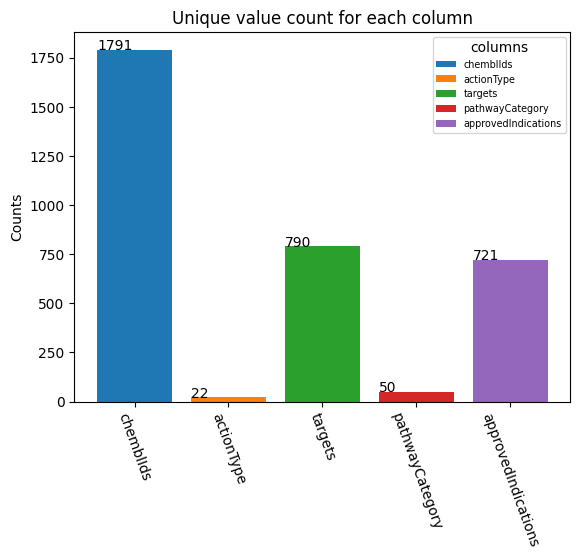

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

columns = clean_drug_targets_moa_pathway_indications.columns.tolist()
counts = clean_drug_targets_moa_pathway_indications.nunique().tolist()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#0000EE','#FFEBCD','#E3CF57']
#bar_labels = ['red', 'blue', '_red', 'orange']
#bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(columns, counts, label=columns, color=colors)
xlocs, xlabs = plt.xticks()

ax.set_ylabel('Counts')
ax.set_title('Unique value count for each column')
ax.legend(title='columns',fontsize ='x-small')
ax.tick_params('x', labelrotation=290)

for i, v in enumerate(counts):
    plt.text(xlocs[i] - 0.40, v + 0.01, str(v))

plt.show()

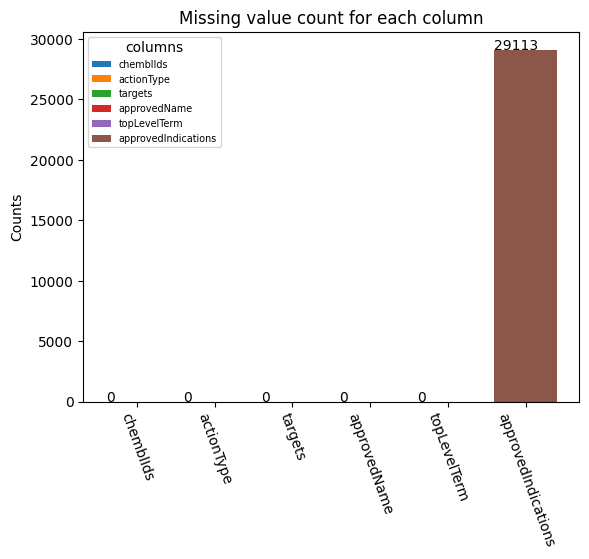

In [314]:
fig_missing, ax_missing = plt.subplots()

columns = clean_drug_targets_moa_pathway_indications.columns.tolist()
missing_count = clean_drug_targets_moa_pathway_indications.isna().sum().tolist()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#0000EE','#FFEBCD','#E3CF57']
#bar_labels = ['red', 'blue', '_red', 'orange']
#bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax_missing.bar(columns, missing_count, label=columns, color=colors)
xlocs, xlabs = plt.xticks()
ax_missing.set_ylabel('Counts')
ax_missing.set_title('Missing value count for each column')
ax_missing.legend(title='columns',fontsize ='x-small')
ax_missing.tick_params('x', labelrotation=290)

for i, v in enumerate(missing_count):
    plt.text(xlocs[i] - 0.40, v + 0.01, str(v))

plt.show()

In [65]:
import scipy
from sklearn import preprocessing
label = preprocessing.LabelEncoder()
from scipy.stats import chi2_contingency
import numpy as np

In [63]:
ae_moa = pd.merge(ae_full_df,clean_drug_targets_moa_pathway_indications, left_on = 'chembl_id', right_on = 'chemblIds', how = 'inner')

ae_moa = ae_moa[['chembl_id','event','actionType','targets','pathwayCategory','approvedIndications']]

In [66]:
data_encoded = pd.DataFrame() 
for i in ae_moa.columns:
    data_encoded[i]=label.fit_transform(ae_moa[i])

In [67]:
def cramers_rule(var1,var2) :
    crosstab=pd.crosstab(index=var1, columns=var2)
    stat = scipy.stats.contingency.association(crosstab)
    return stat

rows=[]  
for var1 in ae_moa.columns.tolist(): 
    col=[]
    for var2 in ae_moa.columns.tolist(): 
        cramers =cramers_rule(ae_moa[var1], ae_moa[var2])
        col.append(round(cramers,2))
    rows.append(col)
cramers_results = np.array(rows) 
craemrs_correlation = pd.DataFrame(cramers_results,columns = data_encoded.columns, index=data_encoded.columns)

In [68]:
craemrs_correlation.style.background_gradient(cmap='YlGnBu')